# Анализ данных
инструмент формирования отчётности

In [ ]:
import sys
sys.path.append('C:/time-calc-TT/scripts')  # для локпака надо рестартить кернел после каждого изменения пакета
import scripts.data_preprocessing as preproc
import scripts.documentation as doc

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


## Матрица корреляции

### Матрица корреляции данных

c:\Users\shiri\anaconda3\envs\pymc_env\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():
c:\time-calc-TT\scripts\data_preprocessing.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["is_italic"] = data["is_italic"].replace({"есть": 1, "нет": 0}).infer_objects(copy=False)


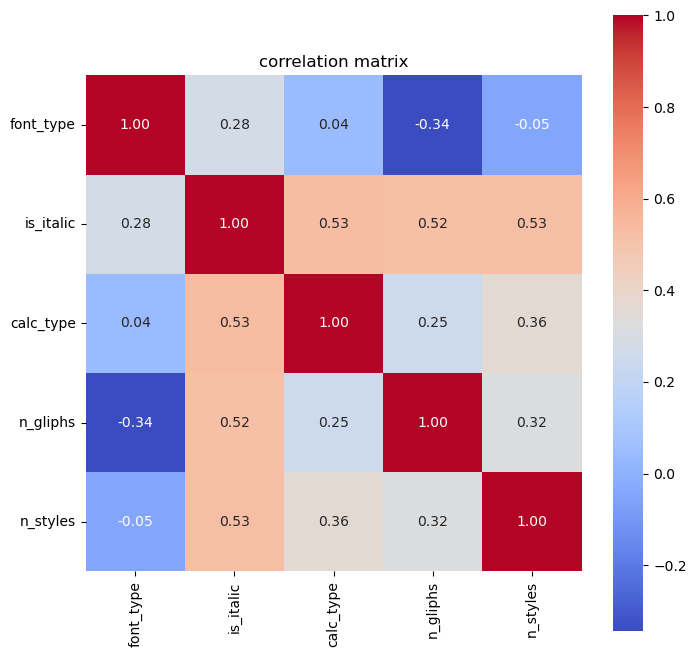

In [127]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_df = preproc.read()['all_data'].drop(list(doc.doc["targets"].keys()), axis=1)
data_df["font_type"] = le.fit_transform(data_df["font_type"])
data_df["calc_type"] = le.fit_transform(data_df["calc_type"])
preproc.correlation_matrix(data_df)

### Матрица корреляции данных после OHE

In [85]:
removed_features = ['font_type_logo']#, 'font_type_handwritten', 'calc_type_logo']

c:\Users\shiri\anaconda3\envs\pymc_env\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():
c:\time-calc-TT\scripts\data_preprocessing.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["is_italic"] = data["is_italic"].replace({"есть": 1, "нет": 0}).infer_objects(copy=False)
c:\time-calc-TT\scripts\data_preprocessing.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_operational = pd.concat(

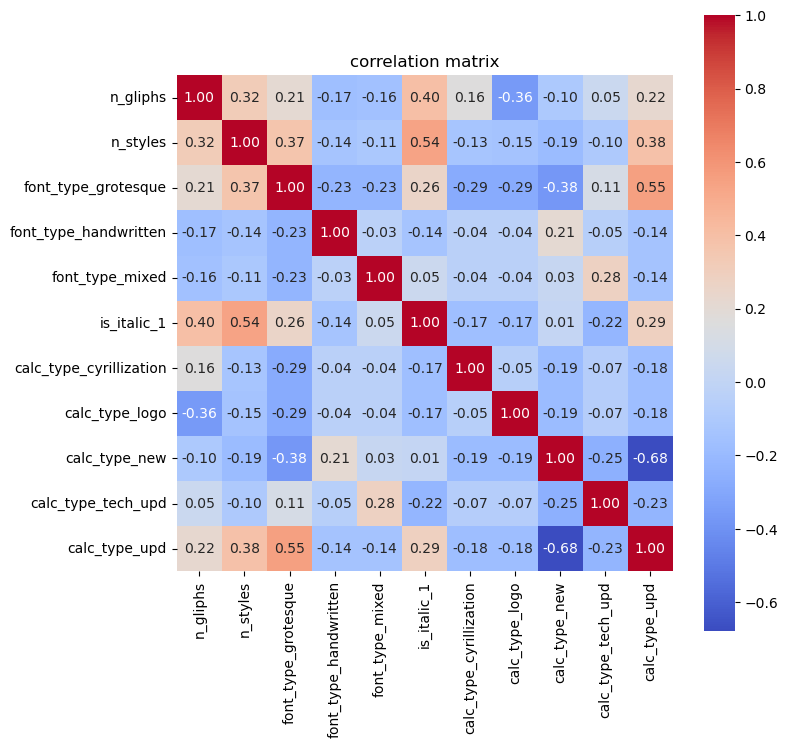

In [86]:
preproc.correlation_matrix(preproc.OHE(preproc.read()["all_data"])["features"].drop(removed_features,axis=1))


**Комменты:**
* `calc_type_new` и `calc_type_upd` сильно кореллированы
* `font_type_logo` и `calc_type_logo` линейно зав с кф 1, выкинуть `font_type_logo`
* прочие признаки слабокореллированы
* фан факт: если выкинуть `calc_type_upd` хитмап станет синим

## Матрица пропусков

желтое - пропуски, фиолетовое - наличие даты

c:\Users\shiri\anaconda3\envs\pymc_env\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():
c:\time-calc-TT\scripts\data_preprocessing.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["is_italic"] = data["is_italic"].replace({"есть": 1, "нет": 0}).infer_objects(copy=False)


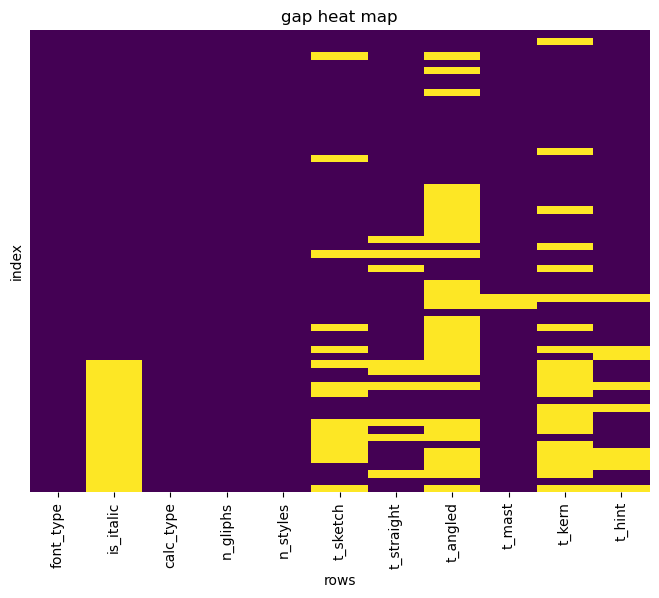

In [83]:
preproc.gap_matrix(preproc.read()["all_data"])

**Комменты:**
* были записи без информации о времязатратах - такие данные удалены так как не несут подкрепления для модели
* пробелов в данных фактически нет - пробелы в таргет значениях - нули
* пробелы в колонке `is_itallic` восполняются значениями `false`

## Оценка важности фичей
Оценим значимость фичей с помощью Random Forest

In [130]:
data_df = preproc.OHE(preproc.read()['all_data'])
X = data_df["features"].drop(removed_features, axis=1)  # выкинули ЛЗ компонент

min_max_scaler = MinMaxScaler()  # скейлим фичи в [0,1]
X = pd.DataFrame(min_max_scaler.fit_transform(X),columns=X.columns,index=X.index)

Y = data_df["targets"]#["t_sketch"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Model = RandomForestRegressor(n_estimators=100, criterion="squared_error")
Model.fit(X_train, Y_train)

Y_pred = Model.predict(X_test)

rrmse = np.sqrt(mean_squared_error(Y_test, Y_pred)) / np.mean(Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'RRMSE: {rrmse}','\n',f'R2: {r2}')

pd.DataFrame(Model.feature_importances_, index=X.columns, columns=["importance"]).sort_values(by=["importance"], ascending=False)


c:\Users\shiri\anaconda3\envs\pymc_env\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():
c:\time-calc-TT\scripts\data_preprocessing.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["is_italic"] = data["is_italic"].replace({"есть": 1, "нет": 0}).infer_objects(copy=False)
c:\time-calc-TT\scripts\data_preprocessing.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_operational = pd.concat(

RRMSE: 1.3471193456464745 
 R2: 0.253936922498251


,importance
is_italic_1,0.463278
n_gliphs,0.198521
n_styles,0.158468
font_type_grotesque,0.113031
calc_type_new,0.040780
calc_type_upd,0.020239
calc_type_tech_upd,0.003215
calc_type_cyrillization,0.001685
font_type_handwritten,0.000441
calc_type_logo,0.000283


**Комменты:**
* `font_type_mixed`, `font_type_handwritten`, `calc_type_logo`, `calc_type_cyrillization`, `calc_type_tech_upd` мало влияют на таргет-вектор
* результат по $R^2$ нестабильный: от -0.01 до 0.5